# Springboard - Data Science Career Track

# Capstone Project I: Kiva.org loan delays

In [1]:
# link for the data
kiva_url = "https://www.kaggle.com/lucian18/mpi-on-regions#all_kiva_loans.csv"

### Goal of the project:
    
**Understand what may cause a higher delay between:**

-  the "posted time" (the time at which the loan is posted on Kiva by the field agent)
-  the "funded time" (the time at which the loan posted to Kiva gets 100% funded by lenders)
- the "disbursed time" (the time at which the loan is disbursed by the field agent to the borrower)

#### **The journey of a Kiva loan**

- A borrower applies for a loan.
- The loan goes through the underwriting and approval process
- If it is approved, the loan disbursal period starts
    - The loan is posted to Kiva for lenders to support
    - Fundraising period
    - Fundraising complete (or not)
- Borrower repays the loan
- Lenders use repayments to fund new loans, donate or withdraw the money.

Partner loans are administered by Kiva’s Field Partners and are available to borrowers in more than 80 countries. Direct loans are made using the digital payment system and don’t involve a Field Partner.

**Note**: *Disbursal* refers to when the borrower can access the money, but the timing of it can vary:    
  - For most Field Partner loans, the money is *pre-disbursed* (when partners give the funds out before the loan is posted), so the borrower can access the funds right away. 
  - For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website.

### Libraries

In [2]:
# relevant modules
%matplotlib inline
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import zscore
from collections import Counter


## 1) Data inspection and Cleaning

In [3]:
# filename
kiva_data = pd.read_csv("all_kiva_loans_copy.csv")

### Overview and cleaning

In [4]:
kiva_data.head(3)

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
0,657307,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,...,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,female,irregular
1,657259,400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",...,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,female,monthly
2,658010,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,...,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,female,monthly


In [5]:
kiva_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 21 columns):
loan_id                    1419607 non-null int64
funded_amount              1419607 non-null float64
loan_amount                1419607 non-null float64
status                     1419607 non-null object
activity_name              1419607 non-null object
sector_name                1419607 non-null object
loan_use                   1376334 non-null object
country_code               1419598 non-null object
country_name               1419607 non-null object
town_name                  1257849 non-null object
currency_policy            1419607 non-null object
currency                   1419607 non-null object
partner_id                 1402817 non-null float64
posted_time                1419607 non-null object
planned_expiration_time    1047773 non-null object
disburse_time              1416794 non-null object
raised_time                1355325 non-null object
lender_term       

In [6]:
# describe dataframe numericals
kiva_data.describe()

,loan_id,funded_amount,loan_amount,partner_id,lender_term,num_lenders_total
count,1.419607e+06,1.419607e+06,1.419607e+06,1.402817e+06,1.419583e+06,1.419607e+06
mean,7.233713e+05,7.961254e+02,8.322284e+02,1.496207e+02,1.305139e+01,2.225389e+01
std,4.156766e+05,1.034257e+03,1.080551e+03,8.769345e+01,7.566660e+00,2.777410e+01
min,8.400000e+01,0.000000e+00,2.500000e+01,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.642165e+05,2.750000e+02,3.000000e+02,9.800000e+01,8.000000e+00,8.000000e+00
50%,7.240350e+05,5.000000e+02,5.000000e+02,1.390000e+02,1.200000e+01,1.500000e+01
75%,1.082972e+06,9.500000e+02,1.000000e+03,1.740000e+02,1.400000e+01,2.700000e+01
max,1.444085e+06,1.000000e+05,1.000000e+05,5.570000e+02,1.950000e+02,3.045000e+03


#### Changing dtpes and labels

In [7]:
# Changing some column names, for clarity
kiva_data.rename(columns={'disburse_time':'disbursed_time', 'raised_time':'funded_time'}, inplace=True)

In [8]:
# change the dtype of the main variables of study to datetime64[ns]
kiva_data['posted_time'] = pd.to_datetime(kiva_data['posted_time'], errors='coerce')
kiva_data['planned_expiration_time'] = pd.to_datetime(kiva_data['planned_expiration_time'], errors='coerce')
kiva_data['disbursed_time'] = pd.to_datetime(kiva_data['disbursed_time'], errors='coerce')
kiva_data['funded_time'] = pd.to_datetime(kiva_data['funded_time'], errors='coerce')

### Main variables inspection and cleaning

#### 1) 'posted_time'

In [9]:
# As seen above, there are no missing values and the filled ones seem to be ok
kiva_data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419607,1416794,1355325
unique,1415162,75668,1137793
top,2006-04-16 07:10:50,2017-02-01 08:00:00,2005-03-31 06:27:55
freq,207,2800,203
first,2006-04-16 07:10:50,2005-04-14 05:27:55,2005-03-31 06:27:55
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


In [10]:
# checking frequency
kiva_data['posted_time'].value_counts().head()

2006-04-16 07:10:50    207
2015-05-27 08:05:17      3
2008-02-12 22:15:45      3
2015-03-12 08:01:30      3
2016-04-26 08:08:20      3
Name: posted_time, dtype: int64

Apparently the 'posted_time' column is clean

#### 2) 'funded_time'

In [11]:
# filled and missing values
kiva_data['funded_time'].isna().value_counts()

False    1355325
True       64282
Name: funded_time, dtype: int64

- Regarding the **missing values**, even though some null-values might correspond to loans which were indeed funded (as seen in the example below), there is not a way to know how to fill those values, and I will not consider the following ones for analysis, so that there is no ambiguity. 

In [12]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0

missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# Note: I considered ok when the funded_amount was larger than the loan_amount, hence the <

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
142677,849172,700.0,700.0,expired,Cereals,Food,to buy maize to sell.,UG,Uganda,Hoima,...,UGX,163.0,2015-03-02 13:07:56,2015-04-06 12:20:02,2015-02-18 08:00:00,NaT,12.0,25,male,monthly
508508,985199,3400.0,3000.0,expired,Farm Supplies,Agriculture,"to pay for wires for the grape orchard, cover ...",AM,Armenia,"Hoktember village, Armavir region",...,USD,169.0,2015-11-25 10:53:00,2015-12-28 19:20:08,2015-10-29 07:00:00,NaT,38.0,84,male,monthly
628009,114629,125.0,125.0,refunded,Retail,Retail,NaN,PH,Philippines,NaN,...,PHP,128.0,2009-06-11 01:27:29,NaT,2009-05-29 07:00:00,NaT,12.0,5,NaN,irregular
657411,38915,1475.0,1475.0,expired,Food Market,Food,To expand fresh food business,UG,Uganda,Nansana,...,UGX,65.0,2008-02-28 07:10:56,NaT,2008-07-22 07:00:00,NaT,NaN,24,"female, female, female, female, female",irregular
809473,924149,425.0,400.0,expired,General Store,Retail,"to buy beverages, rice, laundry detergent, sug...",MZ,Mozambique,"Boane, Maputo",...,MZN,23.0,2015-07-28 07:14:04,2015-09-09 18:30:02,2015-07-22 07:00:00,NaT,17.0,11,male,monthly
861839,147,1000.0,1000.0,refunded,Farming,Agriculture,NaN,BG,Bulgaria,NaN,...,USD,3.0,2006-04-16 07:10:50,NaT,2006-03-15 05:00:00,NaT,6.0,16,NaN,bullet
1368801,408534,1275.0,1275.0,expired,Agriculture,Agriculture,To buy the inventory for his fruit and vegetab...,AZ,Azerbaijan,NaN,...,AZN,207.0,2012-03-24 13:05:34,2012-05-02 15:00:03,2012-03-07 08:00:00,NaT,20.0,44,female,monthly


It is also incoherent if the status appears as funded and there is a missing value in funded_time.

In [13]:
# if there is a row with the status = funded, there should not exist a missing value in funded_time
kiva_data[(kiva_data['funded_time'].isnull()) & (kiva_data['status'] == 'funded')]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


The remaining missing values will be kept due to several reasons. Not every loan is funded, or when there is a filled value in funded_amount, because the loan may not be completely funded yet, that is, the funded_amount is smaller than the loan_amount.

- Regarding the **filled values**, there are 2 columns with which we can compare to check if there are discrepancies:

    - funded_amount and status

*'funded_time' vs 'funded_amount'*

In [14]:
# Comparing with the funded_amount column, there are no discrepancies
kiva_data[(kiva_data['funded_time'].notnull()) & (kiva_data['funded_amount'] > 0)].count()[['funded_time', 'funded_amount']]

funded_time      1355325
funded_amount    1355325
dtype: int64

In [15]:
# However, when looking at the difference between loan_amount and funded_amount, we notice inconsistency in the data
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0] 

# Note: the funded_time is only filled when the loan is 100% funded by lenders

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
60715,57210,925.0,950.0,funded,Clothing,Clothing,Increase business capital,RW,Rwanda,Gasabo/Buliza/Rwanda,...,RWF,117.0,2008-07-17 15:59:58,NaT,2008-08-05 07:00:00,2008-07-22 18:26:42,14.0,35,female,monthly
233811,44276,475.0,500.0,funded,Food Production/Sales,Food,NaN,KE,Kenya,NaN,...,KES,36.0,2008-04-08 13:26:42,NaT,2008-05-03 05:39:35,2008-04-19 05:39:35,14.0,14,NaN,monthly
518536,48958,25.0,950.0,refunded,Food Production/Sales,Food,NaN,SN,Senegal,NaN,...,XOF,105.0,2008-05-15 16:09:47,NaT,2008-05-31 07:00:00,2008-05-17 22:33:56,8.0,1,NaN,monthly
577064,745,125.0,1000.0,refunded,Sewing,Services,NaN,KH,Cambodia,NaN,...,USD,9.0,2006-08-18 09:12:23,NaT,2006-09-11 02:34:47,2006-08-28 02:34:47,21.0,4,NaN,monthly


Therefore, I will not consider these rows too, so the data is clear.

*'funded_time' vs 'status'*

In [16]:
# Comparing with the status column:

# datetime and status columns described
kiva_data[['posted_time', 'funded_time', 'status']].describe()

,posted_time,funded_time,status
count,1419607,1355325,1419607
unique,1415162,1137793,4
top,2006-04-16 07:10:50,2005-03-31 06:27:55,funded
freq,207,203,1350340
first,2006-04-16 07:10:50,2005-03-31 06:27:55,NaN
last,2018-01-11 07:11:23,2018-01-11 03:11:44,NaN


In [17]:
# status column variables
kiva_data['status'].value_counts()

funded         1350340
expired          59081
refunded          6578
fundRaising       3608
Name: status, dtype: int64

In [18]:
# comparing funded_time non nulls with 'status':funded

kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    1350340
status         1350340
dtype: int64

Whenever the loan is described as 'funded', a corresponding value appears in the 'funded_time' column.

In [19]:
# comparing funded_time non nulls with 'status' = refunded

kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    4983
status         4983
dtype: int64

Whenever the loan is described as 'refunded', a corresponding value appears in the 'funded_time' column.

We can see that the sum of the rows where the status is indicated as 'funded' with the ones where it is indicated as 'refunded' has less 2 values than the total number of 'funded_time' values

In [20]:
# funded_time non nulls with 'status':funded
ft_f = kiva_data[(kiva_data['status'] == 'funded') & (kiva_data['funded_time'].notnull())].count().status 

# funded_time non nulls with 'status' = refunded
ft_ref = kiva_data[(kiva_data['status'] == 'refunded') & (kiva_data['funded_time'].notnull())].count().status

# funded_time total non nulls
ft_tot = kiva_data['funded_time'].count()

ft_tot - (ft_f + ft_ref)

2

In [21]:
# comparing funded_time non nulls with 'status' = expired

kiva_data[(kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
926652,601656,925.0,925.0,expired,Home Products Sales,Retail,to purchase clothing and household items for r...,GE,Georgia,Vani,...,GEL,181.0,2013-08-29 13:43:33,2013-10-03 15:10:02,2013-07-31 07:00:00,2013-10-03 15:16:01,15.0,29,female,monthly
1144537,149173,4600.0,4600.0,expired,Retail,Retail,Increase working capital,BO,Bolivia,NaN,...,BOB,73.0,2009-10-30 20:19:53,NaT,2009-10-29 07:00:00,2009-12-01 07:12:13,8.0,125,"female, female, female, female, female, female...",monthly


We have two loans requests which supposedly expired but, at the same time, two values for the 'funded_time' column are filled.

In this case, however, the remaining variables seem to indicate that the loan was indeed funded, so I will consider them for analysis. 
For example, in the first case, what probably classified the status as expired was the fact that the funded_time was slightly after (6 minutes) the planned_expiration_time.

These two values are the ones which were missing from the previous analysis.

I will change the status in these two cases to 'funded'.

In [22]:
to_replace = (kiva_data['status'] == 'expired') & (kiva_data['funded_time'].notnull())

kiva_data.loc[to_replace, 'status'] = 'funded'

In [23]:
# comparing funded_time non nulls with 'status' = fundRaising

kiva_data[(kiva_data['status'] == 'fundRaising') & (kiva_data['funded_time'].notnull())].count()[['funded_time', 'status']]

funded_time    0
status         0
dtype: int64

Therefore, I will consider all values in the 'funded_time' series, null and non-null, with the exception of the following cases:

In [24]:
# rows where there is a missing value in funded_time but (loan_amount - funded_amount) <= 0
missing_ft = kiva_data[kiva_data['funded_time'].isna()] 
not_rows = missing_ft[(missing_ft['loan_amount'] - missing_ft['funded_amount']) <= 0]

# and

# rows where funded_time is not null but (loan_amount - funded_amount) > 0
ft_notnull = kiva_data[kiva_data['funded_time'].notnull()] 
not_rows_2 = ft_notnull[(ft_notnull['loan_amount'] - ft_notnull['funded_amount']) > 0]

I will use a new dataframe named data

In [25]:
# removing the rows
data = kiva_data.drop(not_rows.index)
data = data.drop(not_rows_2.index)

In [26]:
# new shape
data.shape

(1419596, 21)

#### 3) 'disbursed_time'

In [27]:
# filled and missing values
data['disbursed_time'].isna().value_counts()

False    1416783
True        2813
Name: disbursed_time, dtype: int64

- Regarding the **missing values**:

It may be the case that there was a posted_time or funded_time but the disbursal has not occured yet. I will leave those values for further analysis, since they could represent loans which were not delivered or just expected situations.

- Regarding the **filled values**

As said in the introduction, the timing of the disbursal can vary. For most Field Partner loans, the money is pre-disbursed, so the borrower can access the funds right away. Hence, it is not strange if the disbursed_time is made even before the posted_time. For direct loans, the money is disbursed only after the loan has been fully crowdfunded on the Kiva website. 

It can then naturally occur after or before the posted_time or the funded_time.

#### 4) 'posted_time' vs 'funded_time'

As we have seen, the chronological order between the 'posted_time' and the 'disbursal_time' does not matter, as well as between the 'disbursal_time' and the 'funded_time'.

What could biase the data is when the 'funded_time' appears before the 'posted_time'.

In [28]:
# cases
pt_ft_cases = data[data['funded_time'] < data['posted_time']]

# brief look
pt_ft_cases[['funded_time', 'posted_time']].head()

,funded_time,posted_time
85222,2005-03-31 06:27:55,2006-04-16 07:10:50
85369,2005-03-31 06:27:55,2006-04-16 07:10:50
89113,2005-03-31 06:27:55,2006-04-16 07:10:50
99222,2005-03-31 06:27:55,2006-04-16 07:10:50
106582,2005-03-31 06:27:55,2006-04-16 07:10:50


In [29]:
# number of cases where funded_time is made before the posted_time 
pt_ft_cases.count()[['funded_time', 'posted_time']]

funded_time    203
posted_time    203
dtype: int64

In [30]:
# unique dates where funded_time is made before the posted_time
set(pt_ft_cases.posted_time)

{Timestamp('2006-04-16 07:10:50')}

In [31]:
# unique time differences
set(pt_ft_cases['posted_time'] - pt_ft_cases['funded_time'])

{Timedelta('381 days 00:42:55')}

In [32]:
# first posted_time date
min(data['posted_time'])

Timestamp('2006-04-16 07:10:50')

As we can see, these cases correspond to the loans which were first posted by Kiva. I will not consider them for analysis.

In [33]:
# removing the rows
data = data.drop(pt_ft_cases.index)

# new shape
data.shape

(1419393, 21)

#### Other variables

The funded_amount column appears to be compatible with the num_lenders_total column. 

In [34]:
# funded_amount  
print("There are", data['funded_amount'][data['funded_amount'] == 0].count(), "zeros in the column 'funded_amount'")

# num_lenders_total
print("There are", data['num_lenders_total'][data['num_lenders_total'] == 0].count(), "zeros in the column 'num_lenders_total'")

There are 2568 zeros in the column 'funded_amount'
There are 2568 zeros in the column 'num_lenders_total'


If the funded_amount is greater or equal to the loan_amount, then the status should not appear as expired.

In [35]:
data[(data['funded_amount'] >= data['loan_amount']) & (data['status'] == 'expired')]

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval


#### Checking for misspellings

*'activity_name'*

In [36]:
# Create the series of activities
activities = data['activity_name']

# drop duplicates
activities = activities.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = activities.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_activities = activities.loc[mask_inverse]

# printing
invalid_activities 

# Conclusion: everything normal

24                  Fruits & Vegetables
26                Food Production/Sales
83         Cloth & Dressmaking Supplies
144      Primary/secondary school costs
175          Liquor Store / Off-License
553                       Fuel/Firewood
1591                Music Discs & Tapes
3155                 Movie Tapes & DVDs
15965                      Balut-Making
33786           Landscaping / Gardening
Name: activity_name, dtype: object

*'country_name'*

In [37]:
# Create the series of countries
countries = data['country_name']

# drop duplicates
countries = countries.drop_duplicates()

# creating the pattern to look for
pattern = '^[A-Za-z\.\s]*$'

# mask
mask = countries.str.contains(pattern)

# Inverting the mask: mask_inverse
mask_inverse = ~mask

#Subset activities using mask_inverse: invalid_activities
invalid_countries = countries.loc[mask_inverse]

# printing
invalid_countries 

# Conclusion: everything normal

269      Lao People's Democratic Republic
298                       Myanmar (Burma)
491                           Timor-Leste
23390                       Cote D'Ivoire
Name: country_name, dtype: object

### Searching for outliers

***1) 'loan_amount' and 'funded_amount'***

In [38]:
data[['funded_amount', 'loan_amount']].describe()

,funded_amount,loan_amount
count,1.419393e+06,1.419393e+06
mean,7.961659e+02,8.322734e+02
std,1.034322e+03,1.080619e+03
min,0.000000e+00,2.500000e+01
25%,2.750000e+02,3.000000e+02
50%,5.000000e+02,5.000000e+02
75%,9.500000e+02,1.000000e+03
max,1.000000e+05,1.000000e+05


In the previous analysis, when looking at the filled values in the 'funded_time' column, I did not include the cases where the funded_amount was greater than the loan_amount because it is acceptable. It is necessary, however, to check for outliers.

In [39]:
funded_amount_big = data[data['loan_amount'] < data['funded_amount']].funded_amount
loan_amount_small = data[data['loan_amount'] < data['funded_amount']].loan_amount

# general statistics of the difference:  
(funded_amount_big - loan_amount_small).describe()

count    10.000000
mean     27.500000
std       7.905694
min      25.000000
25%      25.000000
50%      25.000000
75%      25.000000
max      50.000000
dtype: float64

The differences are not significant.

Everything appears to be ok with the 'loan_amount' and 'funded_amount' values

***2) Main variables***

In [40]:
data[['posted_time', 'disbursed_time', 'funded_time']].describe()

,posted_time,disbursed_time,funded_time
count,1419393,1416580,1355118
unique,1415152,75663,1137788
top,2015-05-27 08:05:17,2017-02-01 08:00:00,2016-09-21 13:03:24
freq,3,2800,33
first,2006-04-16 07:10:50,2006-05-03 00:11:57,2006-04-19 00:11:57
last,2018-01-11 07:11:23,2018-03-19 07:00:00,2018-01-11 03:11:44


As the main variables fit approximately inside the same dates, there are no outliers regarding each one.

Looking at the differences between them:

***2.1) 'posted_time' and 'funded_time'***

It is not necessary to look for outliers here since we have already excluded for analysis the cases where the funded_time was before the posted_time. The rest of the values we accept them at face value since they are between an acceptable range.

In [41]:
(data['funded_time'] - data['posted_time']).describe()

count                    1355118
mean     12 days 15:14:31.848660
std      13 days 13:00:26.422088
min              0 days 00:02:00
25%       3 days 13:15:20.250000
50%              7 days 18:30:50
75%      18 days 11:47:17.250000
max            533 days 17:22:00
dtype: object

***2.2) 'posted_time' and 'disbursed_time'***

In [42]:
(data['posted_time'] - data['disbursed_time']).describe()

count                    1416580
mean     12 days 04:36:06.951143
std      18 days 04:48:11.167029
min          -540 days +02:23:26
25%       5 days 19:58:28.750000
50%             14 days 02:57:52
75%      25 days 02:15:43.500000
max            118 days 16:28:59
dtype: object

As we have seen, the chronological order of these two dates does not matter, because the disbursal can be made before the posted time for most of the entities (Field partners). It is necessary to check for outliers, though.

Here I will focus only when the disbursal is made before the posted_time.

In [43]:
# defining outliers function based on z-score
def outliers_zscore(diff, threshold):
    zscore_diff = (diff - diff.mean())/diff.std()
    return zscore_diff[(zscore_diff > threshold) | (zscore_diff < -threshold)]

In [44]:
# cases where the disbursal is made before the posted_time
pt_dt_pos = data[data['posted_time'] > data['disbursed_time']]

# time difference between the two
pt_dt_pos_diff = pt_dt_pos['posted_time'] - pt_dt_pos['disbursed_time']

# describe
pt_dt_pos_diff.describe()

count                    1273566
mean     16 days 14:42:00.922162
std       9 days 15:11:11.397535
min              0 days 00:00:03
25%       7 days 20:42:53.250000
50%      16 days 02:17:43.500000
75%             26 days 03:07:27
max            118 days 16:28:59
dtype: object

In [45]:
# outliers for the difference between posted_time and disbursed_time (when positive) with a threshold = 3
outliers_pt_dt = outliers_zscore(pt_dt_pos_diff, 3)

# describe
outliers_pt_dt.describe()

count    135.000000
mean       4.380002
std        1.411533
min        3.023692
25%        3.323745
50%        4.049502
75%        4.600418
max       10.596565
dtype: float64

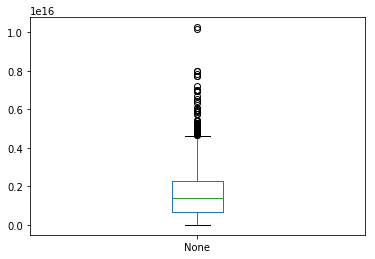

In [46]:
# boxplot
pt_dt_pos_diff.plot(kind='box')

plt.show()

In [47]:
# data regarding these outliers 
data.ix[outliers_pt_dt.index].head()

C:\Users\Utilizador\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
17072,114567,7450.0,7450.0,funded,Computers,Services,Training and certification for his computer an...,US,United States,"Atlanta, Georgia",...,USD,131.0,2009-06-10 20:14:22,NaT,2009-03-22 07:00:00,2009-06-21 02:37:18,26.0,236,male,monthly
17358,117254,175.0,175.0,funded,Pigs,Agriculture,To buy pig feed,PH,Philippines,"Surallah, South Cotabato",...,PHP,125.0,2009-06-22 00:58:11,NaT,2009-05-06 07:00:00,2009-06-22 02:05:24,6.0,6,female,bullet
17418,114264,5750.0,5750.0,funded,Services,Services,To buy a car for transporting packages,US,United States,"Queens, New York",...,USD,131.0,2009-06-09 16:55:37,NaT,2009-03-31 07:00:00,2009-06-20 20:18:43,27.0,171,male,monthly
36690,246230,1500.0,1500.0,funded,Butcher Shop,Food,To purchase meat for resale,KG,Kyrgyzstan,Tokmak,...,KGS,135.0,2010-11-09 05:39:58,NaT,2010-09-14 07:00:00,2010-11-15 18:34:32,7.0,46,"female, female, female, female",monthly
37027,245762,700.0,700.0,funded,Restaurant,Food,Purchase of ingredients,PH,Philippines,"Puerto Princesa, Palawan",...,PHP,145.0,2010-11-06 11:49:45,NaT,2010-09-20 07:00:00,2010-11-06 23:45:16,8.0,26,female,irregular


There are a few outliers regarding this case. However, when analysing them, we notice that in all of them the difference between the posted_time and funded_time is acceptable, which means that although the disbursal was made long before the posted_time, the loan got funded almost immediatly. This could suggest that these cases were somehow managed by Kiva or the Field Partners.

I will opt for their maintenance in the analysis.

In [48]:
# the difference between the funded_time and posted_time in these outliers
(data.ix[outliers_pt_dt.index]['funded_time'] - data.ix[outliers_pt_dt.index]['posted_time']).describe()

C:\Users\Utilizador\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


count                       135
mean     7 days 11:06:35.251851
std      8 days 06:36:41.484789
min             0 days 00:56:53
25%             2 days 16:39:58
50%             3 days 22:15:03
75%             8 days 06:18:38
max            39 days 14:23:22
dtype: object

**2.3) 'funded_time' and 'disbursed_time'**

In [49]:
(data['funded_time'] - data['disbursed_time']).describe()

count                    1354847
mean     24 days 16:56:53.510973
std      19 days 18:17:54.516253
min          -183 days +15:28:03
25%      13 days 08:16:07.500000
50%             26 days 03:41:37
75%             36 days 08:18:57
max            157 days 06:55:22
dtype: object

Here I focused on the cases on the cases where the disbursed_time was filled after the loan was funded. I left apart the cases where the disbursed_time appeared before the funded_time.


In [50]:
# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disbursed_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

I will now divide the analysis between the cases when there was a field partner involved and when there was not.

*Field partner involved*

In [51]:
# cases where the disbursal is made after the funded_time, where there is a field partner involved
dt_ft_pos_partner = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].notnull())]

# time difference between the two
dt_ft_pos_diff_partner = dt_ft_pos_partner['disbursed_time'] - dt_ft_pos_partner['funded_time']

# describe
dt_ft_pos_diff_partner.describe()

count                     104590
mean     17 days 06:47:49.884291
std      12 days 20:47:08.139505
min              0 days 00:01:24
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max             88 days 23:25:52
dtype: object

In [52]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, with a field partner
outliers_dt_ft_partner = outliers_zscore(dt_ft_pos_diff_partner, 3)

# describe
outliers_dt_ft_partner.describe()

count    3214.000000
mean        4.192525
std         0.765157
min         3.002844
25%         3.487668
50%         4.166138
75%         4.916974
max         5.572261
dtype: float64

*Field partner not involved*

In [53]:
# cases where the disbursal is made after the funded_time, where there is not a field partner involved
dt_ft_pos_partner_not = data[(data['disbursed_time'] > data['funded_time']) & (data['partner_id'].isnull())]

# time difference between the two
dt_ft_pos_diff_partner_not = dt_ft_pos_partner_not['disbursed_time'] - dt_ft_pos_partner_not['funded_time']

# describe
dt_ft_pos_diff_partner_not.describe()

count                      13030
mean      8 days 14:59:16.826477
std      10 days 20:39:23.626387
min              0 days 00:00:17
25%       2 days 20:21:33.750000
50%              5 days 12:25:15
75%       9 days 13:06:44.250000
max            182 days 08:31:57
dtype: object

In [54]:
# outliers for the difference between disbursed_time and funded_time with a threshold = 3, and NO field partner
outliers_dt_ft_partner_not = outliers_zscore(dt_ft_pos_diff_partner_not, 3)

# describe
outliers_dt_ft_partner_not.describe()

count    301.000000
mean       4.579016
std        1.698910
min        3.001596
25%        3.346945
50%        3.989094
75%        5.169267
max       15.996315
dtype: float64

In [55]:
# distribution among countries of the outliers with a field partner involved
data.ix[outliers_dt_ft_partner.index].country_name.value_counts()

C:\Users\Utilizador\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Kenya                 787
Nigeria               565
Ghana                 493
India                 336
South Africa          263
Somalia               136
Senegal                78
Tanzania               77
Costa Rica             61
Myanmar (Burma)        41
Colombia               41
Nicaragua              32
Mozambique             28
Malawi                 26
Belize                 24
Kyrgyzstan             24
Mexico                 20
Honduras               16
Moldova                16
Dominican Republic     14
Haiti                  14
Suriname               12
Georgia                11
Thailand               10
Zambia                  9
Mongolia                8
Peru                    8
Jordan                  7
Sierra Leone            7
Vietnam                 7
Cambodia                7
Pakistan                4
Turkey                  4
Indonesia               4
China                   4
Uganda                  4
Mali                    4
Zimbabwe                4
Namibia     

In [56]:
# distribution among countries of the outliers with no field partner involved
data.ix[outliers_dt_ft_partner_not.index].country_name.value_counts()

C:\Users\Utilizador\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Kenya            290
United States     11
Name: country_name, dtype: int64

Looking at the distribution of the outliers among countries, however, we notice that they are somewhat representative, either with or without a partner involved, so I will opt to keep the values for further analysis.

### 2) Data Story

In [57]:
###########################################################################################################

### Exploratory data analysis

- When there is a missing disbursed_time value and the loan has been funded:

In [58]:
# Cases where there is a missing disbursed_time and the status is classified as funded
missing_disb = data[(data['disbursed_time'].isna()) & (data['funded_time'].notnull())]
missing_disb.count().funded_time

271

In [59]:
# head
missing_disb.head()

,loan_id,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,...,currency,partner_id,posted_time,planned_expiration_time,disbursed_time,funded_time,lender_term,num_lenders_total,borrower_genders,repayment_interval
37765,1407950,8000.0,8000.0,funded,Clothing,Clothing,support a local business dedicated to providin...,US,United States,NaN,...,USD,NaN,2017-11-02 01:11:32,2017-12-17 22:44:40,NaT,2017-12-16 21:14:45,36.0,56,male,bullet
70179,1164746,3000.0,3000.0,refunded,Services,Services,NaN,US,United States,NaN,...,USD,NaN,2016-10-05 01:28:13,2016-11-10 18:43:40,NaT,2016-11-10 00:40:29,24.0,57,NaN,bullet
70314,1088448,5000.0,5000.0,refunded,Agriculture,Agriculture,NaN,US,United States,NaN,...,USD,NaN,2015-04-15 12:35:57,2015-06-05 00:30:01,NaT,2016-02-11 17:44:48,30.0,106,NaN,bullet
89049,1428619,2000.0,2000.0,funded,Entertainment,Entertainment,fund the renovation of my retail store so my b...,US,United States,NaN,...,USD,NaN,2017-12-05 18:50:15,2018-01-20 12:38:16,NaT,2017-12-23 14:32:29,18.0,25,male,bullet
91347,1084914,125.0,125.0,refunded,Clothing,Clothing,NaN,KE,Kenya,NaN,...,KES,NaN,2014-10-28 06:32:19,2014-12-27 17:45:36,NaT,2014-12-26 19:09:42,3.0,12,NaN,bullet


In [60]:
# general delay, taking into consideration the time of the last disbursal in the data
(max(data['disbursed_time']) - missing_disb['funded_time']).describe()

count                         271
mean     856 days 10:38:41.136531
std      378 days 19:22:38.747084
min              78 days 20:59:20
25%             915 days 17:32:43
50%             931 days 14:42:34
75%             970 days 17:55:31
max            1927 days 06:24:45
Name: funded_time, dtype: object

In [61]:
# As seen before,

# cases where the disbursal is made after the funded_time
dt_ft_pos = data[data['disbursed_time'] > data['funded_time']]

# time difference between the two
dt_ft_pos_diff = dt_ft_pos['disbursed_time'] - dt_ft_pos['funded_time']

# describe
dt_ft_pos_diff.describe()

count                     117620
mean     16 days 07:46:33.561018
std      12 days 22:45:01.896489
min              0 days 00:00:17
25%             14 days 00:00:00
50%             14 days 00:00:00
75%             14 days 00:00:00
max            182 days 08:31:57
dtype: object

There is a general significant difference between the two.

In [62]:
# geographical location of the missing values
missing_disb.country_name.value_counts()

Kenya            216
United States     55
Name: country_name, dtype: int64

In [63]:
# sector name of those missing values 
missing_disb.sector_name.value_counts()

# Note: 97% of the Agriculture cases are from Kenya

Agriculture       79
Food              46
Services          46
Retail            44
Clothing          26
Arts               9
Transportation     7
Construction       5
Health             4
Entertainment      4
Education          1
Name: sector_name, dtype: int64

Since the missing values appear in only two countries in the world, I will generalize and check for outliers by comparing them with the typical delay to disburse in each country.

USA

In [64]:
# cases in the United States where the disbursal is made after the loan is funded
usa_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'United States']

# delay values 
delay_usa = (usa_dt_ft_pos['disbursed_time'] - usa_dt_ft_pos['funded_time'])

# description of the delay to disburse in the United States
print(delay_usa.describe())

# I will consider the mean value for the typical delay to disburse in the United States
delay_usa.mean()

count                      3527
mean     5 days 06:43:32.021831
std      5 days 22:55:18.397383
min             0 days 00:00:17
25%             2 days 00:26:18
50%             3 days 23:05:12
75%      6 days 05:07:38.500000
max           106 days 12:48:50
dtype: object


Timedelta('5 days 06:43:32.021831')

In [65]:
# missing values filtered by country: United States
usa = missing_disb[missing_disb['country_name'] == 'United States']

# description of the delay of disbursal, in the United States, after the loan is funded 
(max(data['disbursed_time']) - usa['funded_time']).describe()

count                          55
mean     248 days 10:26:48.945454
std      398 days 00:49:45.201273
min              78 days 20:59:20
25%       80 days 17:18:49.500000
50%              82 days 14:37:29
75%              99 days 17:58:27
max            1927 days 06:24:45
Name: funded_time, dtype: object

In [66]:
## what to consider for these cases ? which ones are expected?

# 106 (max diff) vs 82 (median)

Kenya

In [67]:
# cases in Kenya where the disbursal is made after the loan is funded
kenya_dt_ft_pos = dt_ft_pos[dt_ft_pos['country_name'] == 'Kenya']

# delay values 
delay_kenya = (kenya_dt_ft_pos['disbursed_time'] - kenya_dt_ft_pos['funded_time'])

# description of the delay to disburse in Kenya
print(delay_kenya.describe())

# I will consider the mean value for the typical delay to disburse in Kenya
delay_kenya.mean()

count                      20659
mean     17 days 11:42:49.691708
std      17 days 07:31:00.633473
min              0 days 00:02:00
25%              5 days 06:34:47
50%             13 days 12:58:22
75%      24 days 14:37:12.500000
max            182 days 08:31:57
dtype: object


Timedelta('17 days 11:42:49.691708')

In [68]:
# missing values filtered by country: Kenya
kenya = missing_disb[missing_disb['country_name'] == 'Kenya']

# description of the delay of disbursal, in Kenya, after the loan is funded
(max(data['disbursed_time']) - kenya['funded_time']).describe()

count                          216
mean     1011 days 06:15:02.481481
std       147 days 12:35:07.238205
min              914 days 11:19:07
25%              921 days 01:30:39
50%       942 days 19:49:48.500000
75%             1023 days 09:07:22
max             1600 days 10:20:21
Name: funded_time, dtype: object

In Kenya, they are all off the scale. I shall consider these values as non-distributed.